In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout,AveragePooling2D, Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils, plot_model
from keras.layers import Conv2D, Input
import keras

import tensorflow as tf


from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 11s 0us/step


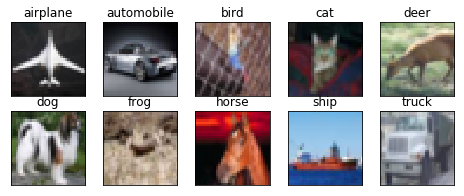

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Added Regularization

In [0]:
import keras.backend as K
def loss_with_reg(model, batch_size, _lambda = 0.001):
  reg_loss_sqr = 0
  for layer in model.layers:
    if len(layer.get_weights()) > 0:
      reg_loss_sqr += np.sum(layer.get_weights()[0]**2)
  reg_loss_sqr = reg_loss_sqr * (_lambda/2*batch_size)
    
  def temp(y_true,y_pred):
    return K.categorical_crossentropy(y_true, y_pred)+reg_loss_sqr
  return temp

# Space to depth conversion

- space_to_depth() is a lambda function for space to depth layer.This layer helps to connect two layers whose channels are of not same resolution
- this function takes input tensor as an input and reduces the size of the channels by a factor of block_size and returns the converted tensor
  - Let us consider the input channels have a shape of 32X32X64 then if the channel size is reduced by a factor of 2 then of this converted channels of size (32/2)X(32/2)X(64*2^2)
  - ie : 32X32X64 => 16X16X256
- _block_size_ parameter is the factor by which the space to depth reduction should be done
  - if the block_size is 2 then conversion would be 32X32X64 => 16X16X256
  - if the block_size is 4 then conversion would be 32X32X64 => 8X8X1024
  
  

In [0]:
def space_to_depth(x, block_size = 2):
  return tf.nn.space_to_depth(
    x,
    block_size,
    name="space_to_depth",
    data_format='NHWC'
  )


## CNN Classifier Model Generated by ENAS implementation

- I have implemented the CNN of the architecture shown in the below image
![ENAS architecture](images/enasdiscoverednetwork.png)
- I have tried to use the names of the variables as clear as possible to understand
- I have concatenated the channels .Instead of adding

In [9]:
batch_size = 200

input_img = Input(shape=(32, 32, 3))

x1 = SeparableConv2D(32, 5, padding='same')(input_img)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
x1 = Dropout(0.1)(x1)
x1_std_1 = Lambda(space_to_depth, arguments={'block_size':2})(x1)
x1_std_2 = Lambda(space_to_depth, arguments={'block_size':4})(x1)



x2 = Convolution2D(32, 5, padding='same')(x1)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)
x2 = Dropout(0.1)(x2)
x2_std_2 = Lambda(space_to_depth, arguments={'block_size':4})(x2)


x3 = Convolution2D(32, 5 ,padding='same')(x2)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)
x3 = Dropout(0.1)(x3)
x3_std_1 = Lambda(space_to_depth, arguments={'block_size':2})(x3)
x3_std_2 = Lambda(space_to_depth, arguments={'block_size':4})(x3)



x1_x3 = keras.layers.concatenate([x1, x3], axis=3)
x4 = SeparableConv2D(32, 5, padding='same')(x1_x3)
x4 = BatchNormalization()(x4)
x4 = Activation('relu')(x4)
x4 = Dropout(0.1)(x4)
x4_std_1 = Lambda(space_to_depth, arguments={'block_size':2})(x4)
x4_std_2 = Lambda(space_to_depth, arguments={'block_size':4})(x4)


x1_x4 = keras.layers.concatenate([x1, x4], axis=3)
x5 = MaxPooling2D(pool_size=(2, 2))(x1_x4)

x6 = SeparableConv2D(32, 3, padding='same')(x5)
x6 = BatchNormalization()(x6)
x6 = Activation('relu')(x6)
x6 = Dropout(0.1)(x6)
x6_std_1 = Lambda(space_to_depth, arguments={'block_size':2})(x6)

x4_x1_x6 = keras.layers.concatenate([x4_std_1, x1_std_1, x6], axis=3)
x7 = Convolution2D(32, 5, padding='same')(x4_x1_x6)
x7 = BatchNormalization()(x7)
x7 = Activation('relu')(x7)
x7 = Dropout(0.1)(x7)
x7_std_1 = Lambda(space_to_depth, arguments={'block_size':2})(x7)

x6_x4_x3_x7 = keras.layers.concatenate([x6, x4_std_1, x3_std_1, x7], axis=3)
x8 = SeparableConv2D(32, 3, padding='same')(x6_x4_x3_x7)
x8 = BatchNormalization()(x8)
x8 = Activation('relu')(x8)
x8 = Dropout(0.1)(x8)
x8_std_1 = Lambda(space_to_depth, arguments={'block_size':2})(x8)


x7_x6_x4_x3_x1_x8 = keras.layers.concatenate([x7, x6, x4_std_1, x3_std_1,x1_std_1, x8], axis=3)
x9 = SeparableConv2D(32, 5, padding='same')(x7_x6_x4_x3_x1_x8)
x9 = BatchNormalization()(x9)
x9 = Activation('relu')(x9)
x9 = Dropout(0.1)(x9)

x8_x6_x4_x1_x9 = keras.layers.concatenate([x8, x6, x4_std_1,x1_std_1, x9], axis=3)
x10 = MaxPooling2D(pool_size=(2, 2))(x8_x6_x4_x1_x9)

x7_x4_x1_x10 = keras.layers.concatenate([x7_std_1, x4_std_2,x1_std_2, x10], axis=3)
x11 = Convolution2D(32, 5, padding='same')(x7_x4_x1_x10)
x11 = BatchNormalization()(x11)
x11 = Activation('relu')(x11)
x11 = Dropout(0.1)(x11)

x8_x6_x4_x2_x11 = keras.layers.concatenate([x8_std_1, x6_std_1, x4_std_2, x2_std_2, x11], axis=3)
x12 = SeparableConv2D(32, 5, padding='same')(x8_x6_x4_x2_x11)
x12 = BatchNormalization()(x12)
x12 = Activation('relu')(x12)
x12 = Dropout(0.1)(x12)

x11_x3_x2_x12 = keras.layers.concatenate([x11, x3_std_2, x2_std_2, x12], axis=3)
x13 = Convolution2D(32, 3, padding='same')(x11_x3_x2_x12)
x13 = BatchNormalization()(x13)
x13 = Activation('relu')(x13)
x13 = Dropout(0.1)(x13)

x12_x8_x6_x4_x3_x1_x13 = keras.layers.concatenate([x12, x8_std_1, x6_std_1, x4_std_2, x3_std_2, x1_std_2, x13], axis=3)
x14 = SeparableConv2D(32, 5, padding='same')(x12_x8_x6_x4_x3_x1_x13)
x14 = BatchNormalization()(x14)
x14 = Activation('relu')(x14)
x14 = Dropout(0.1)(x14)

x12_x8_x4_x14 = keras.layers.concatenate([x12, x8_std_1, x4_std_2, x14], axis=3)
x15 = Convolution2D(10, 1, padding='same')(x12_x8_x4_x14)
x15 = BatchNormalization()(x15)
x15 = Activation('relu')(x15)
x15 = Dropout(0.1)(x15)
x16 = AveragePooling2D(pool_size=(8, 8))(x15)


x = Flatten()(x16)
output = Activation("softmax")(x)

model = Model(inputs=input_img, outputs=output)

model.compile(optimizer='adam', loss=loss_with_reg(model,batch_size, _lambda = 0.0025), metrics=['accuracy'])

model.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 32)   203         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           ba

## Below picture shows the image of model
![model](images/model.png)

> Else running the following cell will generate a picture along with displaying model image in output

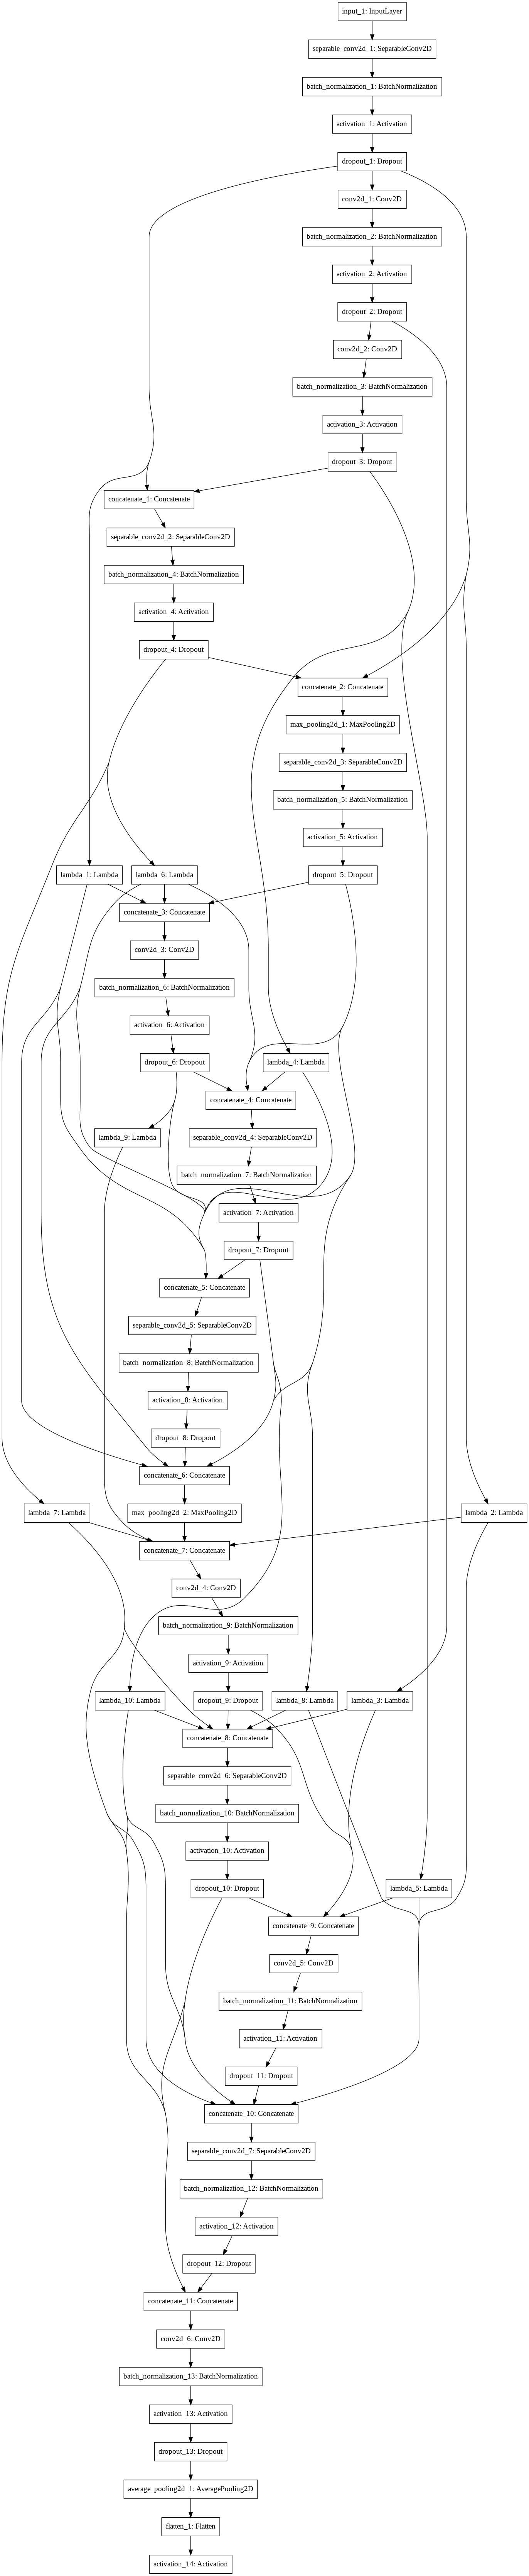

In [10]:
plot_model(model, to_file='model.png')

## Ran the ENAS model on the CIFAR-10 data gave a validation accuracy of 84.6%


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=250, epochs=100)`
  from ipykernel import kernelapp as app


Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
250/250 [==============================] - 106s 422ms/step - loss: 169.7404 - acc: 0.5081 - val_loss: 169.8947 - val_acc: 0.4626
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0024610336.
250/250 [==============================] - 96s 384ms/step - loss: 169.2916 - acc: 0.6554 - val_loss: 170.2221 - val_acc: 0.4154
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0020862309.
250/250 [==============================] - 96s 385ms/step - loss: 169.1108 - acc: 0.7190 - val_loss: 169.4334 - val_acc: 0.6139
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0018105009.
250/250 [==============================] - 96s 385ms/step - loss: 168.9999 - acc: 0.7556 - val_loss: 169.1905 - val_acc: 0.6746
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0015991471.
250/250 [==============================] - 96s 385ms/step - loss: 168.9

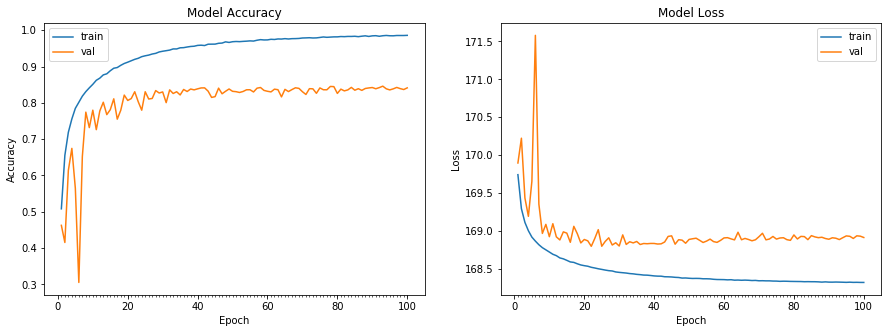

Accuracy on test data is: 84.24


In [11]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True,
                             zoom_range=0.0, 
                             horizontal_flip=True)

def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.219 * epoch), 10)
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = batch_size),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = datagen.flow(test_features, test_labels, batch_size = int(test_features.shape[0]/5)) , verbose=1, callbacks = [LearningRateScheduler(scheduler, verbose=1)])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))#76 rf 40
